In [1]:
import kagglehub
import os
import shutil

# Download the dataset
try:
    base_path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
    print("Path to dataset files:", base_path)
except Exception as e:
    print("Error downloading dataset:", e)
    exit()

# Path to the Kaggle dataset's data.yaml
kaggle_data_yaml_path = os.path.join(base_path, "YOLO_format/data.yaml")

# If the file already exists from the downloaded dataset, remove it
if os.path.exists(kaggle_data_yaml_path):
    os.remove(kaggle_data_yaml_path)
    print("Removed the original data.yaml from the Kaggle dataset.")

# Path to your custom data.yaml in the emotion_recognition folder
local_data_yaml_path = "./data.yaml"

# Copy your custom data.yaml to the dataset folder
shutil.copy(local_data_yaml_path, kaggle_data_yaml_path)
print("Replaced with local data.yaml from the emotion_recognition folder.")


Path to dataset files: /Users/alexhofman/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2
Removed the original data.yaml from the Kaggle dataset.
Replaced with local data.yaml from the emotion_recognition folder.


In [ ]:
import os
import cv2
import glob
from tqdm import tqdm
import yaml
import csv
import uuid  # for unique filenames

def get_image_base(filename):
    """
    Given a filename like "ffhq_2.jpg" or "ffhq_2_cropped.jpg" or "image0000020.png",
    return the "base":
      - If it starts with "ffhq", then join the first two parts: "ffhq_2"
      - Otherwise, just take the first part: "image0000020"
    """
    name, _ = os.path.splitext(filename)      # remove extension
    parts = name.split('_')
    if len(parts) > 1 and parts[0] == 'ffhq':
        return '_'.join(parts[:2])  # e.g. "ffhq_2"
    else:
        return parts[0]            # e.g. "image0000020"

def yolo_to_xyxy(label_line, img_width, img_height):
    """
    Convert YOLO label line (class_id, x_center, y_center, width, height)
    from normalized coords [0-1] to absolute pixel coords [x_min, y_min, x_max, y_max].
    """
    parts = label_line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * img_width
    y_center = float(parts[2]) * img_height
    w = float(parts[3]) * img_width
    h = float(parts[4]) * img_height

    x_min = int(x_center - w / 2)
    y_min = int(y_center - h / 2)
    x_max = int(x_center + w / 2)
    y_max = int(y_center + h / 2)

    # Clip to image boundaries
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img_width, x_max)
    y_max = min(img_height, y_max)

    return class_id, x_min, y_min, x_max, y_max


def process_split(yaml_dict, split_name, out_dir, csv_writer):
    """
    Process one split (train, valid, or test).
    - yaml_dict: loaded from data.yaml
    - split_name: 'train', 'val', or 'test'
    - out_dir: where to store all cropped images for this split (still "mixed")
    - csv_writer: CSV writer to record (filename, class_id) rows
    """

    # e.g. for train:
    images_dir = yaml_dict[split_name]         # "/kaggle/.../train/images"
    labels_dir = images_dir.replace("images", "labels")

    # 1) First, detect which images have already been processed in out_dir
    #    so we can skip them.
    existing_crops = os.listdir(out_dir)
    processed_bases = set()
    for cropped_file in existing_crops:
        base = get_image_base(cropped_file)
        processed_bases.add(base)

    # 2) Collect all image paths in the main dataset
    img_paths = glob.glob(os.path.join(images_dir, "*.*"))  # jpg, png, etc.

    for img_path in tqdm(img_paths, desc=f"Processing {split_name}"):
        basename = os.path.basename(img_path)        # e.g. "image_12.png"
        filebase, _ = os.path.splitext(basename)     # e.g. "image_12"

        # Figure out the "base" for this image.
        main_base = get_image_base(basename)
        if main_base in processed_bases:
            # We've already done this image. Skip.
            continue

        label_path = os.path.join(labels_dir, filebase + ".txt")
        if not os.path.exists(label_path):
            print(f"Label file not found for: {img_path}")
            continue  # no label, skip

        image = cv2.imread(img_path)
        if image is None:
            continue  # corrupted or unreadable
        h, w, _ = image.shape

        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print(f"Label file is empty: {label_path}")
            continue

        # 3) Process each bounding box
        for line in lines:
            class_id, x_min, y_min, x_max, y_max = yolo_to_xyxy(line, w, h)
            crop = image[y_min:y_max, x_min:x_max]
            if crop.size == 0:
                continue  # empty crop, skip

            # Generate a unique filename so we don't overwrite
            unique_id = str(uuid.uuid4())[:8]  
            out_filename = f"{filebase}_{unique_id}.jpg"
            out_path = os.path.join(out_dir, out_filename)

            # Save the cropped face
            cv2.imwrite(out_path, crop)

            # Write a row in the CSV: [cropped_filename, class_id]
            csv_writer.writerow([out_filename, class_id])

        # 4) Since we've now processed this image, add its base to the set
        processed_bases.add(main_base)


def main():
    """
    Example usage: 
    1) Reads data.yaml
    2) Processes train, val, test
    3) Saves all cropped faces in separate 'cropped_mixed/train', 'cropped_mixed/val', 'cropped_mixed/test' dirs
    4) For each split, writes a CSV file with 'filename,class_id'
    """
    # Path to your data.yaml
    yaml_path = os.path.join(base_path, "YOLO_format/data.yaml")
    with open(yaml_path, 'r') as f:
        yaml_dict = yaml.safe_load(f)

    # Replace ${HOME} with the actual home directory
    for key, value in yaml_dict.items():
        if isinstance(value, str) and "${HOME}" in value:
            yaml_dict[key] = value.replace("${HOME}", os.path.expanduser("~"))

    # Create a base output folder
    base_out = "cropped_mixed"
    os.makedirs(base_out, exist_ok=True)

    # We'll process each split separately, but keep them "mixed" (no subfolders by class)
    for split_name in ["train", "val", "test"]:
        out_dir = os.path.join(base_out, split_name)
        os.makedirs(out_dir, exist_ok=True)

        csv_path = os.path.join(out_dir, f"{split_name}_labels.csv")

        # 1) If there's already a CSV, read its contents so we don't lose them
        existing_rows = []
        if os.path.exists(csv_path):
            with open(csv_path, 'r') as f:
                reader = csv.reader(f)
                existing_rows = list(reader)  # old header + data rows

        # 2) Open the same file in 'w' mode, so we can rewrite old + new
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # Write your header again
            writer.writerow(["filename", "class_id"])

            # 3) Re-write the old rows (skipping the old header if needed)
            for row in existing_rows[1:]:
                writer.writerow(row)

            # 4) Call process_split to add new (cropped) rows
            process_split(yaml_dict, split_name, out_dir, writer)



if __name__ == "__main__":
    main()


Processing test: 100%|██████████| 2755/2755 [00:01<00:00, 1604.84it/s]


In [17]:
import os
import textwrap
import warnings
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# facenet-pytorch
from facenet_pytorch import InceptionResnetV1

In [26]:
class FaceDataset(Dataset):
    def __init__(self, images_dir, csv_path, transform=None):
        """
        images_dir: folder containing cropped face images
        csv_path: CSV file with 'filename,class_id'
        transform: torchvision transforms to apply
        """
        self.images_dir = images_dir
        self.transform = transform
        self.samples = []

        with open(csv_path, 'r') as f:
            reader = csv.DictReader(f)  # handles "filename,class_id" header automatically
            for row in reader:
                fn = row['filename']
                label = int(row['class_id'])
                self.samples.append((fn, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        img_path = os.path.join(self.images_dir, filename)
        
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [30]:
class FaceNetClassifier(nn.Module):
    def __init__(self, num_emotions=8, freeze_facenet=True):
        super(FaceNetClassifier, self).__init__()
        # 1) Load FaceNet
        self.facenet = InceptionResnetV1(pretrained='vggface2').eval()
        
        if freeze_facenet:
            for param in self.facenet.parameters():
                param.requires_grad = False
        
        # 2) Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),    # first dense
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),    # second dense
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_emotions)  # final logits
        )

    def forward(self, x):
        # If facenet is in eval mode and freeze_facenet=True, it uses no_grad().
        # For partial fine-tuning, we set freeze_facenet=False & call train() on it 
        # or just manually set requires_grad to True for certain layers.
        with torch.no_grad() if not self.facenet.training else torch.enable_grad():
            embeddings = self.facenet(x)  # shape: (batch_size, 512)
        out = self.classifier(embeddings)
        return out
    
    def model_summary(self):
        print("FaceNetClassifier model:")
        print("  Feature extractor: InceptionResnetV1")
        print("  Classifier head:")
        # Convert the classifier to a string and indent it with 4 spaces
        classifier_str = textwrap.indent(str(self.classifier), "    ")
        print(classifier_str)

    def test_model(self, test_loader, criterion, device):
        self.eval()  # Set the entire model to evaluation mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Turn off gradient calculation for inference
        with torch.no_grad():
            for images, labels in test_loader:
                # Move data to the appropriate device (CPU or GPU)
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass using the whole model (feature extractor + classifier)
                outputs = self(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)  # Sum loss over the batch
                
                # Compute predictions and accumulate correct predictions
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy
        test_loss = running_loss / total
        test_acc = correct / total
        return test_loss, test_acc

In [31]:
from cgi import test


warnings.filterwarnings("ignore", category=FutureWarning)

model = FaceNetClassifier()
model.model_summary()

criterion = nn.CrossEntropyLoss()
# And a device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move your model to the device
model.to(device)

# Evaluate the model
test_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])
test_dir = "cropped_mixed/test"
test_csv = os.path.join(test_dir, "test_labels.csv")
test_dataset = FaceDataset(test_dir, test_csv, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loss, test_acc = model.test_model(test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.3f} ... (⌒_⌒;)")

FaceNetClassifier model:
  Feature extractor: InceptionResnetV1
  Classifier head:
    Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=128, out_features=8, bias=True)
    )


KeyboardInterrupt: 

In [18]:
import copy
import torch
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5):
    """
    Enhanced training loop using CosineAnnealingLR:
      - Tracks train/val loss & accuracy each epoch
      - Saves best model weights based on val_acc
      - Returns model and metric lists for plotting
    """
    model = model.to(device)
    
    # LR Scheduler: CosineAnnealingLR over 'epochs' cycles
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch [{epoch+1}/{epochs}] started...")
        
        # -------- TRAIN MODE --------
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in tqdm(enumerate(train_loader),
                                               total=len(train_loader),
                                               desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------- EVAL MODE --------
        model.eval()
        val_loss_total = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss_total += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss_total / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Step the LR scheduler
        scheduler.step()
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            print("Current LR:", current_lr)

        # Save the best model if val_acc improved
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print(f"Best val_acc across all epochs: {best_acc:.4f}")
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model + metric lists
    return model, (train_losses, train_accuracies, val_losses, val_accuracies, best_acc)


Total training samples: 17101
Using device: cuda
CUDA Available: True
Starting training...
Epoch [1/15] started...


Training Epoch 1: 100%|██████████| 268/268 [02:22<00:00,  1.89it/s]


Current LR: 9.890738003669029e-05
Epoch [1/15], Train Loss: 2.0160, Train Acc: 0.2474, Val Loss: 1.7238, Val Acc: 0.3838
Epoch [2/15] started...


Training Epoch 2: 100%|██████████| 268/268 [01:20<00:00,  3.31it/s]


Current LR: 9.567727288213005e-05
Epoch [2/15], Train Loss: 1.5483, Train Acc: 0.4173, Val Loss: 1.2888, Val Acc: 0.5200
Epoch [3/15] started...


Training Epoch 3: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Current LR: 9.045084971874738e-05
Epoch [3/15], Train Loss: 1.3085, Train Acc: 0.5152, Val Loss: 1.1321, Val Acc: 0.5864
Epoch [4/15] started...


Training Epoch 4: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Current LR: 8.345653031794292e-05
Epoch [4/15], Train Loss: 1.1860, Train Acc: 0.5731, Val Loss: 1.0433, Val Acc: 0.6276
Epoch [5/15] started...


Training Epoch 5: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Current LR: 7.500000000000001e-05
Epoch [5/15], Train Loss: 1.0940, Train Acc: 0.6130, Val Loss: 0.9792, Val Acc: 0.6478
Epoch [6/15] started...


Training Epoch 6: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Current LR: 6.545084971874738e-05
Epoch [6/15], Train Loss: 1.0346, Train Acc: 0.6362, Val Loss: 0.9458, Val Acc: 0.6635
Epoch [7/15] started...


Training Epoch 7: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Current LR: 5.522642316338269e-05
Epoch [7/15], Train Loss: 0.9952, Train Acc: 0.6500, Val Loss: 0.9125, Val Acc: 0.6713
Epoch [8/15] started...


Training Epoch 8: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Current LR: 4.4773576836617344e-05
Epoch [8/15], Train Loss: 0.9592, Train Acc: 0.6666, Val Loss: 0.8955, Val Acc: 0.6763
Epoch [9/15] started...


Training Epoch 9: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Current LR: 3.454915028125264e-05
Epoch [9/15], Train Loss: 0.9203, Train Acc: 0.6817, Val Loss: 0.8885, Val Acc: 0.6781
Epoch [10/15] started...


Training Epoch 10: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Current LR: 2.5000000000000018e-05
Epoch [10/15], Train Loss: 0.8867, Train Acc: 0.6953, Val Loss: 0.8790, Val Acc: 0.6820
Epoch [11/15] started...


Training Epoch 11: 100%|██████████| 268/268 [01:20<00:00,  3.32it/s]


Current LR: 1.654346968205711e-05
Epoch [11/15], Train Loss: 0.8682, Train Acc: 0.7036, Val Loss: 0.8951, Val Acc: 0.6805
Epoch [12/15] started...


Training Epoch 12: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Current LR: 9.549150281252635e-06
Epoch [12/15], Train Loss: 0.8440, Train Acc: 0.7097, Val Loss: 0.8962, Val Acc: 0.6820
Epoch [13/15] started...


Training Epoch 13: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Current LR: 4.322727117869952e-06
Epoch [13/15], Train Loss: 0.8369, Train Acc: 0.7126, Val Loss: 0.8857, Val Acc: 0.6802
Epoch [14/15] started...


Training Epoch 14: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Current LR: 1.092619963309716e-06
Epoch [14/15], Train Loss: 0.8271, Train Acc: 0.7170, Val Loss: 0.8762, Val Acc: 0.6846
Epoch [15/15] started...


Training Epoch 15: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Current LR: 0.0
Epoch [15/15], Train Loss: 0.8143, Train Acc: 0.7230, Val Loss: 0.8806, Val Acc: 0.6868
Best val_acc across all epochs: 0.6868
Training completed!


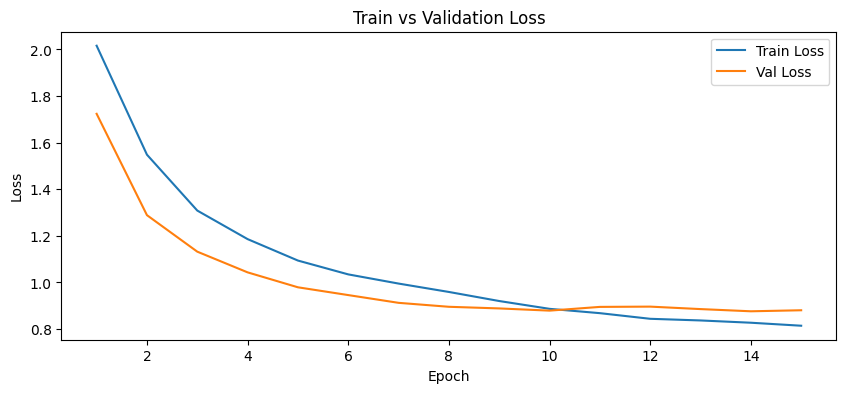

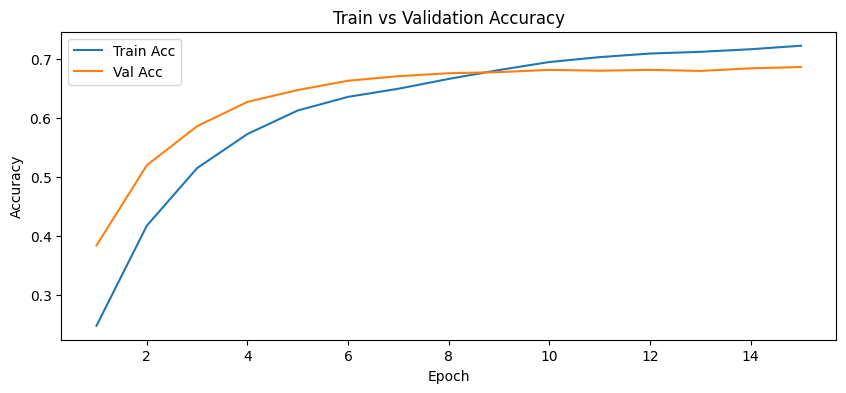

AttributeError: 'FaceNetClassifier' object has no attribute 'best_acc'

In [19]:
def main():
    # 1. Paths to your dataset
    train_dir = "cropped_mixed/train"
    train_csv = os.path.join(train_dir, "train_labels.csv")
    val_dir = "cropped_mixed/val"
    val_csv = os.path.join(val_dir, "val_labels.csv")

    # 2. Augmentations
    #    Heavier train augmentation, lighter val transform
    train_transform = transforms.Compose([
        # Random crop approach
        transforms.Resize((180, 180)),       # make it bigger first
        transforms.RandomCrop((160, 160)),   # then random crop to 160x160
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        # Random Erasing
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
    ])

    val_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])

    # 3. Datasets & DataLoaders
    train_dataset = FaceDataset(train_dir, train_csv, transform=train_transform)
    val_dataset = FaceDataset(val_dir, val_csv, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    print(f"Total training samples: {len(train_loader.dataset)}")

    # 4. Initialize model, loss, optimizer, device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("CUDA Available:", torch.cuda.is_available())
    if device == "cuda":
        print("CUDA Device Name:", torch.cuda.get_device_name(0))

    # freeze_facenet=False to allow partial or full fine-tuning
    model = FaceNetClassifier(num_emotions=8, freeze_facenet=False)

    for name, param in model.facenet.named_parameters():
    # Unfreeze if the name contains one of these blocks
        # if any(b in name for b in ["block0", "block1", "block6", "block7", "block8"]):
        #     param.requires_grad = True
        # else:
        #     param.requires_grad = False

        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=1e-4
    )

    # 5. Train
    print("Starting training...")
    trained_model, metrics = train_model(
        model, criterion, optimizer, 
        train_loader, val_loader, 
        device, epochs=15
    )
    print("Training completed!")

    train_losses, train_accuracies, val_losses, val_accuracies, best_acc = metrics

    # Example plotting with matplotlib
    import matplotlib.pyplot as plt

    epochs_range = range(1, len(train_losses)+1)

    # Model summary
    print(trained_model)

    # Plot history
    plt.figure(figsize=(10,4))
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10,4))
    plt.plot(epochs_range, train_accuracies, label='Train Acc')
    plt.plot(epochs_range, val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.show()


    # 6. Save your best model
    torch.save(trained_model, f"models/facenet_ec_{best_acc:0.4}.pth")
    print("Model saved as facenet_emotion_classifier.pth")

if __name__ == "__main__":
    main()

when freezing the last couple of layers (block7, block8, and last_bn) i was getting 69% (it was always less then 70%) and when i unfreeze all i started getting 75.4% and considering i have 17k images to train and strong data augmentation, unfreezing all of the pre trained model made more sense